In [1]:
import cv2 
from matplotlib import pyplot as plt

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [3]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_train.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_val.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_test.csv", r"C:\Users\lucyc\Desktop\face_loc_d")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [4]:
a, b, c = next(iter(val_loader))

In [5]:
a.shape

torch.Size([128, 3, 24, 24])

In [6]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [7]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [9]:
class RNet(nn.Module):

    def __init__(self):
        super(RNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 28, 3)  #24 -> 22 -> maxp -> 11
        self.conv2 = nn.Conv2d(28, 48, 3) #11 -> 9 -> maxp -> 4
        self.conv3 = nn.Conv2d(48, 64, 2) #4 -> 3

        self.linear1 = nn.Linear(64*3*3, 128)

        self.face_det = nn.Linear(128, 2)
        self.bbox = nn.Linear(128, 4)
        self.landmark = nn.Linear(128, 10)

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #22
        x = F.max_pool2d(x, 2) #11
        x = F.relu(self.conv2(x)) #9
        x = F.max_pool2d(x, 2) #4
        x = F.relu(self.conv3(x)) #3

        x = x.view(-1, 64*3*3)
        x = F.relu(self.linear1(x))

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        return facedet, bbox, landmark


In [10]:
losscrs = torch.nn.CrossEntropyLoss()
class RNetLoss(nn.Module):
    def __init__(self):
        super(RNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([1], device=device))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0.5 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [14]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = RNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = RNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


RNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
for i in range(3):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset), i)

        
    

1 56.08915328979492 0.2804457664489746 128 178783 0
2 45.797786712646484 0.509434700012207 256 178783 0
3 50.050296783447266 0.7596861839294433 384 178783 0
4 58.02367401123047 1.0498045539855958 512 178783 0
5 67.1181869506836 1.3853954887390136 640 178783 0
6 56.7942008972168 1.6693664932250976 768 178783 0
7 47.558807373046875 1.907160530090332 896 178783 0
8 55.30888748168945 2.1837049674987794 1024 178783 0
9 56.874794006347656 2.4680789375305174 1152 178783 0
10 50.84721755981445 2.72231502532959 1280 178783 0
11 48.636497497558594 2.965497512817383 1408 178783 0
12 51.01494216918945 3.2205722236633303 1536 178783 0
13 65.34974670410156 3.547320957183838 1664 178783 0
14 65.22844696044922 3.873463191986084 1792 178783 0
15 49.378963470458984 4.1203580093383785 1920 178783 0
16 43.23185348510742 4.336517276763916 2048 178783 0
17 48.63954162597656 4.579714984893799 2176 178783 0
18 48.83798599243164 4.823904914855957 2304 178783 0
19 52.81314468383789 5.087970638275147 2432 178783

In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [17]:

criterion = RNetLoss()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 2.4574203491210938 2.4574203491210938 32 14898
2 3.728027582168579 3.0927239656448364 64 14898
3 2.540447235107422 2.9086317221323648 96 14898
4 4.25405216217041 3.244986832141876 128 14898
5 2.640634775161743 3.1241164207458496 160 14898
6 3.4796533584594727 3.1833725770314536 192 14898
7 3.8111813068389893 3.27305953843253 224 14898
8 2.943222761154175 3.2318299412727356 256 14898
9 2.8454060554504395 3.188893953959147 288 14898
10 4.184516429901123 3.2884562015533447 320 14898
11 2.820634603500366 3.2459269653667104 352 14898
12 3.61151385307312 3.2763925393422446 384 14898
13 2.7772486209869385 3.2379968533149133 416 14898
14 3.4744904041290283 3.2548892498016357 448 14898
15 2.5700762271881104 3.2092350482940675 480 14898
16 1.8705722093582153 3.1255686208605766 512 14898
17 3.4135985374450684 3.1425115571302524 544 14898
18 4.062824726104736 3.193640066517724 576 14898
19 2.4672329425811768 3.155408112626327 608 14898
20 3.650832414627075 3.180179327726364 640 14898
21 3.298667

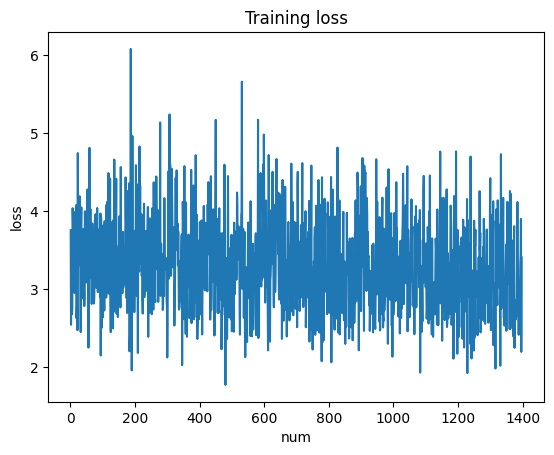

In [18]:
# draw loss curve
plt.plot(train_x, train_loss_y, label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [19]:
# 保存模型
torch.save(model, 'face_loc_r_1_NN.pth')

In [61]:
# load model
model_trained = torch.load('face_loc_r_1_NN.pth')
model_trained.eval()  # 设置模型为评估/测试模式


RNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)

In [62]:
aa = iter(test_loader)

In [63]:

a, b, c = next(aa)

In [64]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"

In [65]:
right = 0
total = 0
for i in range(128):

    #visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    #print(is_face(c[i]))

    with torch.no_grad():
        face_det, bbox, landmark = model_trained(a[i].to(device))
    probabilities = F.softmax(face_det, dim=1)
    print(probabilities)
    # print(bbox)
    # print(landmark)

    # if probabilities[0][0] > probabilities[0][1]:
    #     print("face")
    #     visualize_transformed_image(a[i],get_argsn(bbox[0]),get_argsn(landmark[0]))   
    # else:
    #     print("not face")
    #     visualize_transformed_image(a[i],[0,0,0,0],None)
    
    if probabilities[0][0] > probabilities[0][1] and is_face(c[i]) == "face":
        right += 1
    if probabilities[0][0] < probabilities[0][1] and is_face(c[i]) == "not face":
        right += 1

    total += 1

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/128))

tensor([[0.3161, 0.6839]], device='cuda:0')
tensor([[0.2721, 0.7279]], device='cuda:0')
tensor([[0.5424, 0.4576]], device='cuda:0')
tensor([[0.9612, 0.0388]], device='cuda:0')
tensor([[0.8443, 0.1557]], device='cuda:0')
tensor([[0.0554, 0.9446]], device='cuda:0')
tensor([[0.1280, 0.8720]], device='cuda:0')
tensor([[0.6471, 0.3529]], device='cuda:0')
tensor([[0.3278, 0.6722]], device='cuda:0')
tensor([[0.9270, 0.0730]], device='cuda:0')
tensor([[0.2939, 0.7061]], device='cuda:0')
tensor([[0.9792, 0.0208]], device='cuda:0')
tensor([[0.1095, 0.8905]], device='cuda:0')
tensor([[0.7834, 0.2166]], device='cuda:0')
tensor([[0.9574, 0.0426]], device='cuda:0')
tensor([[0.9341, 0.0659]], device='cuda:0')
tensor([[0.7674, 0.2326]], device='cuda:0')
tensor([[0.9411, 0.0589]], device='cuda:0')
tensor([[0.4183, 0.5817]], device='cuda:0')
tensor([[0.6250, 0.3750]], device='cuda:0')
tensor([[0.1086, 0.8914]], device='cuda:0')
tensor([[0.3643, 0.6357]], device='cuda:0')
tensor([[0.8826, 0.1174]], devic

In [68]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"
    
# load model
model_trained = torch.load('face_loc_r_1_NN.pth')
model_trained.eval()  # 设置模型为评估/测试模式
test_dataset = iter(test_loader)

right = 0
total = 0
for a,b,c in test_dataset:
    try:
        for i in range(128):

            with torch.no_grad():
                face_det, bbox, landmark = model_trained(a[i].to(device))
            probabilities = F.softmax(face_det, dim=1)

            if probabilities[0][0] > probabilities[0][1] and is_face(c[i]) == "face":
                right += 1
            if probabilities[0][0] < probabilities[0][1] and is_face(c[i]) == "not face":
                right += 1

            total += 1
    except:
        pass

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/total))

total: 90362
right: 74018
accuracy: 0.819127509351276
